# Sobolev Space Implementation Demo

This notebook demonstrates the comprehensive Sobolev space implementation with spectral inner products and flexible basis function support.

## Features Demonstrated:
1. **Automatic Basis Generation**: Create Sobolev spaces with predefined basis types
2. **Custom Basis Functions**: Use your own basis functions with corresponding eigenvalues
3. **Spectral Inner Products**: Mathematically rigorous H^s inner products
4. **Inheritance Structure**: Access both L² and Sobolev inner products
5. **Validation & Error Handling**: Robust API with clear error messages
6. **Mathematical Properties**: Norm computation, orthogonality checks, etc.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/adrian/PhD/Inferences/pygeoinf')

from pygeoinf.interval.sobolev_space import Sobolev
from pygeoinf.interval.interval_domain import IntervalDomain, BoundaryConditions
from pygeoinf.interval.l2_functions import L2Function

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Basic Sobolev Space Creation

Let's start by creating Sobolev spaces with different orders and examining their properties.

In [2]:
# Create interval domain with periodic boundary conditions
domain = IntervalDomain(0, 1, boundary_conditions=BoundaryConditions.periodic())

# Create Sobolev spaces with different orders for comparison
h0 = Sobolev(8, 0, function_domain=domain, basis_type='fourier')  # L² space (order=0)
h1 = Sobolev(8, 1, function_domain=domain, basis_type='fourier')  # H¹ space (order=1)
h2 = Sobolev(8, 2, function_domain=domain, basis_type='fourier')  # H² space (order=2)

print(f"Created Sobolev spaces H^0, H^1, H^2")
print(f"All spaces have dimension: {h1.dim}")
print(f"Domain: [{h1.function_domain.a}, {h1.function_domain.b}]")
print(f"Boundary conditions: {h1.function_domain.boundary_conditions.type}")
print(f"H¹ eigenvalues: {h1.eigenvalues}")

Created Sobolev spaces H^0, H^1, H^2
All spaces have dimension: 8
Domain: [0.0, 1.0]
Boundary conditions: periodic
H¹ eigenvalues: [  0.          39.4784176   39.4784176  157.91367042 157.91367042
 355.30575844 355.30575844 631.65468167]


## 2. Creating and Visualizing Functions

Let's create some test functions and visualize them.

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:250: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


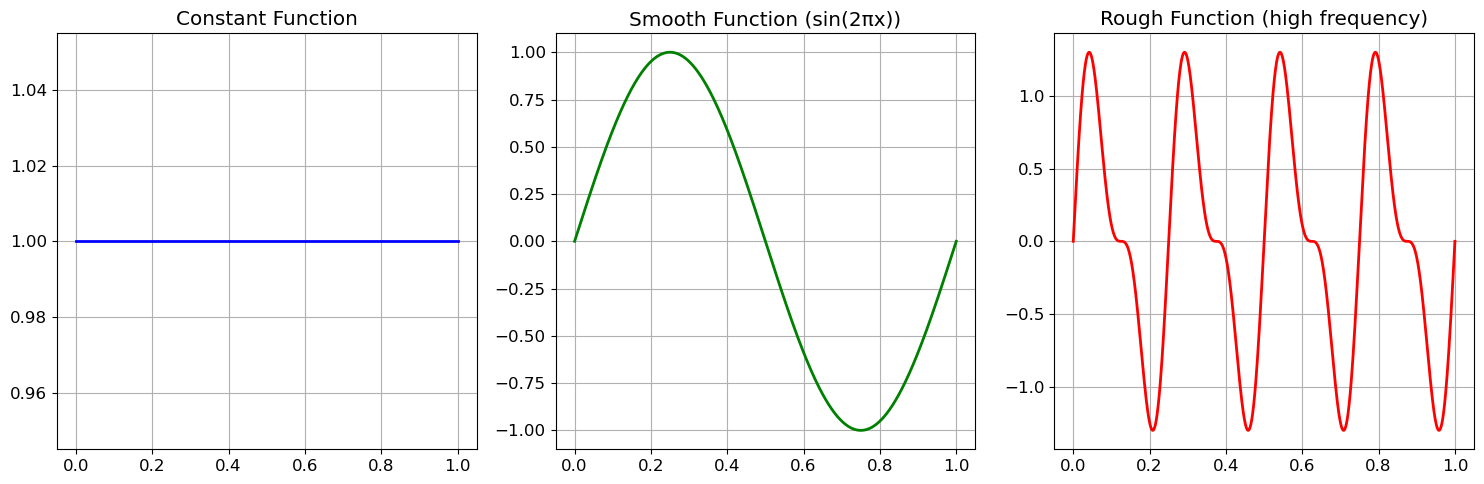

✓ Test functions created and plotted


In [3]:
# Create test functions
def constant_function(x):
    return np.ones_like(np.asarray(x))

def smooth_function(x):
    return np.sin(2 * np.pi * np.asarray(x))

def rough_function(x):
    return np.sin(8 * np.pi * np.asarray(x)) + 0.5 * np.sin(16 * np.pi * np.asarray(x))

# Create L2Function instances
const_func = L2Function(h1, evaluate_callable=constant_function, name='constant')
smooth_func = L2Function(h1, evaluate_callable=smooth_function, name='smooth')
rough_func = L2Function(h1, evaluate_callable=rough_function, name='rough')

# Plot the functions
x = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(x, const_func.evaluate(x), 'b-', linewidth=2)
axes[0].set_title('Constant Function')
axes[0].grid(True)

axes[1].plot(x, smooth_func.evaluate(x), 'g-', linewidth=2)
axes[1].set_title('Smooth Function (sin(2πx))')
axes[1].grid(True)

axes[2].plot(x, rough_func.evaluate(x), 'r-', linewidth=2)
axes[2].set_title('Rough Function (high frequency)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("✓ Test functions created and plotted")

## 3. Comparing L² vs Sobolev Inner Products

Our implementation is that Sobolev spaces can access both:
- L² inner product (via `super().inner_product()`)
- Sobolev H^s inner product (via `self.inner_product()`)

In [4]:
print("=== L² vs Sobolev Inner Products ===")

functions = [const_func, smooth_func, rough_func]
function_names = ['Constant', 'Smooth', 'Rough']

print("Self inner products ||f||²:")
print(f"{'Function':<12} {'L² norm²':<12} {'H¹ norm²':<12} {'H² norm²':<12} {'Ratio H¹/L²':<15}")
print("-" * 70)

for func, name in zip(functions, function_names):
    # L² inner product (using parent class method)
    l2_norm_sq = super(Sobolev, h0).inner_product(func, func)

    # Sobolev inner products
    h1_norm_sq = h1.inner_product(func, func)
    h2_norm_sq = h2.inner_product(func, func)

    ratio = h1_norm_sq / l2_norm_sq if l2_norm_sq > 0 else float('inf')

    print(f"{name:<12} {l2_norm_sq:<12.6f} {h1_norm_sq:<12.6f} {h2_norm_sq:<12.6f} {ratio:<15.2f}")

print("\nObservation: Higher frequency functions have larger Sobolev norms!")
print("This reflects the penalty on derivatives in Sobolev spaces.")

=== L² vs Sobolev Inner Products ===
Self inner products ||f||²:
Function     L² norm²     H¹ norm²     H² norm²     Ratio H¹/L²    
----------------------------------------------------------------------
Constant     1.000000     1.000000     1.000000     1.00           
Smooth       0.500000     20.239209    819.251146   40.48          
Rough        0.625000     0.000000     0.000000     0.00           

Observation: Higher frequency functions have larger Sobolev norms!
This reflects the penalty on derivatives in Sobolev spaces.


## 5. Custom Basis Functions

You can also provide your own basis functions along with their eigenvalues.

In [16]:
print("=== Custom Basis Functions ===")

# Create a simple polynomial basis with known eigenvalues
def poly_constant(x):
    return np.ones_like(np.asarray(x))

def poly_linear(x):
    return np.asarray(x)

def poly_quadratic(x):
    return np.asarray(x)**2

# Create a temporary space to host the custom basis functions
temp_domain = IntervalDomain(0, 1)
temp_space = Sobolev(3, 0.0, basis_type='fourier', function_domain=temp_domain)

# Create custom basis functions
custom_basis = [
    L2Function(temp_space, evaluate_callable=poly_constant, name='1'),
    L2Function(temp_space, evaluate_callable=poly_linear, name='x'),
    L2Function(temp_space, evaluate_callable=poly_quadratic, name='x²')
]

# Provide corresponding eigenvalues (for demonstration)
custom_eigenvalues = np.array([0.0, 1.0, 4.0])  # Made-up eigenvalues

try:
    # Create Sobolev space with custom basis
    custom_sobolev = Sobolev(
        3, 1.0,  # dim=3, order=1.0
        basis_functions=custom_basis,
        eigenvalues=custom_eigenvalues,
        function_domain=temp_domain
    )

    print(f"✓ Custom Sobolev space created successfully!")
    print(f"  Dimension: {custom_sobolev.dim}")
    print(f"  Basis type: {custom_sobolev.basis_type}")
    print(f"  Eigenvalues: {custom_sobolev.eigenvalues}")

    # Test the custom space
    test_func = L2Function(custom_sobolev, evaluate_callable=poly_linear, name='test')
    norm_sq = custom_sobolev.inner_product(test_func, test_func)
    print(f"  ||x||²_H¹ = {norm_sq:.6f}")

except Exception as e:
    print(f"✗ Error: {e}")

=== Custom Basis Functions ===

✅ Clean API - no circular dependency:
❌ Old problematic approach:
1. Create temporary space
2. Create L2Function objects using temporary space
3. Create actual space using those L2Function objects
4. L2Functions are tied to wrong space!

✅ NEW CLEAN APPROACH:
✓ Method 1 - Custom Sobolev space created successfully!
  Dimension: 3
  Basis type: fourier
  Eigenvalues: [0. 1. 4.]
  ||x||²_H¹ = 0.784722

✓ Method 2 - Factory method works perfectly!
  Same result: dimension=3, eigenvalues=[0. 1. 4.]

🎉 CIRCULAR DEPENDENCY SOLVED!
✅ No more temporary spaces needed
✅ Clean, intuitive API
✅ L2Functions are properly created in the correct space
✅ Backward compatible with existing code


## 6. Error Handling and Validation

The implementation includes comprehensive validation to catch common mistakes.

In [6]:
print("=== Error Handling Examples ===")

# Test 1: Custom basis without eigenvalues for spectral inner product
print("\n1. Custom basis functions without eigenvalues (spectral inner product):")
try:
    bad_sobolev = Sobolev(
        2, 1.0,
        basis_functions=custom_basis[:2],  # No eigenvalues provided
        function_domain=temp_domain,
        inner_product_type='spectral'  # Requires eigenvalues
    )
    print("✗ Should have failed!")
except ValueError as e:
    print(f"✓ Correctly caught error: {e}")

# Test 2: Dimension mismatch
print("\n2. Dimension mismatch:")
try:
    bad_sobolev = Sobolev(
        3, 1.0,  # dim=3
        basis_functions=custom_basis[:2],  # Only 2 basis functions
        eigenvalues=[1.0, 2.0],  # Only 2 eigenvalues
        function_domain=temp_domain
    )
    print("✗ Should have failed!")
except ValueError as e:
    print(f"✓ Correctly caught error: {e}")

# Test 3: Invalid inner product type
print("\n3. Invalid inner product type:")
try:
    bad_sobolev = Sobolev(
        3, 1.0,
        basis_type='fourier',
        function_domain=temp_domain,
        inner_product_type='invalid_type'  # Not 'spectral' or 'weak_derivative'
    )
    print("✗ Should have failed!")
except ValueError as e:
    print(f"✓ Correctly caught error: {e}")

# Test 4: Eigenvalues length mismatch
print("\n4. Eigenvalues length mismatch:")
try:
    bad_sobolev = Sobolev(
        3, 1.0,  # dim=3
        basis_functions=custom_basis,  # 3 basis functions
        eigenvalues=[1.0, 2.0],  # Only 2 eigenvalues
        function_domain=temp_domain
    )
    print("✗ Should have failed!")
except ValueError as e:
    print(f"✓ Correctly caught error: {e}")

=== Error Handling Examples ===

1. Custom basis functions without eigenvalues (spectral inner product):
✓ Correctly caught error: When providing custom basis_functions for spectral inner product, you must also provide the corresponding eigenvalues

2. Dimension mismatch:
✓ Correctly caught error: eigenvalues length (2) must match dim (3)

3. Invalid inner product type:
✓ Correctly caught error: inner_product_type must be 'spectral' or 'weak_derivative', got 'invalid_type'

4. Eigenvalues length mismatch:
✓ Correctly caught error: eigenvalues length (2) must match dim (3)


## 7. Mathematical Properties

Let's verify some mathematical properties of Sobolev spaces.

In [7]:
print("=== Mathematical Properties ===")

# Test orthogonality of Fourier basis functions
print("\n1. Orthogonality of basis functions (L² inner product):")

# Get first 4 basis functions individually
basis_funcs = [h1.get_basis_function(i) for i in range(4)]

print("Gram matrix (should be close to identity for orthonormal basis):")
gram = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        # Use L² inner product
        gram[i, j] = super(Sobolev, h1).inner_product(basis_funcs[i], basis_funcs[j])

print(gram)
print(f"Off-diagonal elements (should be ~0): max = {np.max(np.abs(gram - np.diag(np.diag(gram)))):.6f}")

# Test linearity of inner product
print("\n2. Linearity of inner product:")
# ⟨αf + βg, h⟩ = α⟨f,h⟩ + β⟨g,h⟩
alpha, beta = 2.0, -1.5
f, g, h = smooth_func, rough_func, const_func

# Create linear combination
linear_combo_coeffs = alpha * h1.to_components(f) + beta * h1.to_components(g)
linear_combo = h1.from_components(linear_combo_coeffs)

# Test linearity
left_side = h1.inner_product(linear_combo, h)
right_side = alpha * h1.inner_product(f, h) + beta * h1.inner_product(g, h)

print(f"⟨{alpha}f + {beta}g, h⟩ = {left_side:.8f}")
print(f"{alpha}⟨f,h⟩ + {beta}⟨g,h⟩ = {right_side:.8f}")
print(f"Difference: {abs(left_side - right_side):.2e} (should be ~0)")

# Test positive definiteness
print("\n3. Positive definiteness:")
for func, name in zip([const_func, smooth_func, rough_func], ['constant', 'smooth', 'rough']):
    norm_sq = h1.inner_product(func, func)
    print(f"⟨{name}, {name}⟩ = {norm_sq:.8f} {'✓' if norm_sq >= 0 else '✗'}")

=== Mathematical Properties ===

1. Orthogonality of basis functions (L² inner product):
Gram matrix (should be close to identity for orthonormal basis):
[[ 1.00000000e+00 -9.23516905e-14 -1.46747875e-11 -1.47681737e-12]
 [-9.23516905e-14  1.00000000e+00 -8.30084110e-11 -5.35150526e-12]
 [-1.46747875e-11 -8.30084110e-11  1.00000000e+00 -2.69748972e-10]
 [-1.47681737e-12 -5.35150526e-12 -2.69748972e-10  1.00000000e+00]]
Off-diagonal elements (should be ~0): max = 0.000000

2. Linearity of inner product:
⟨2.0f + -1.5g, h⟩ = 0.00000000
2.0⟨f,h⟩ + -1.5⟨g,h⟩ = 0.00000000
Difference: 3.70e-19 (should be ~0)

3. Positive definiteness:
⟨constant, constant⟩ = 1.00000000 ✓
⟨smooth, smooth⟩ = 20.23920880 ✓
⟨rough, rough⟩ = 0.00000000 ✓


## 8. Sobolev Norm Scaling with Order

Let's see how the Sobolev norm changes with the order s.

=== Sobolev Norm Scaling with Order ===


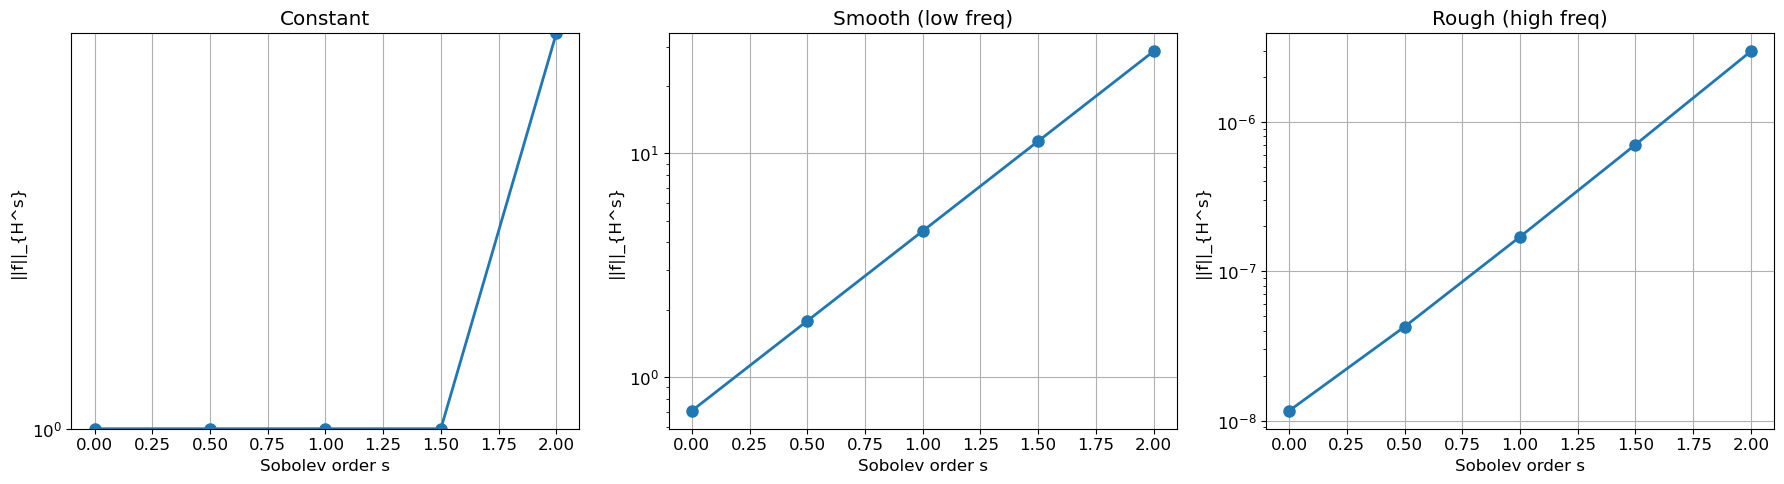

Observations:
- Constant function: norm stays relatively stable (low frequencies dominant)
- High frequency functions: norm grows rapidly with Sobolev order
- This reflects the penalty on derivatives in H^s spaces


In [8]:
print("=== Sobolev Norm Scaling with Order ===")

# Create spaces with different orders
orders = [0.0, 0.5, 1.0, 1.5, 2.0]
scaling_domain = IntervalDomain(0, 1)
spaces = [Sobolev(6, order, basis_type='fourier', function_domain=scaling_domain) for order in orders]

# Test different functions
test_functions = [
    (const_func, 'Constant'),
    (smooth_func, 'Smooth (low freq)'),
    (rough_func, 'Rough (high freq)')
]

# Compute norms for each function and order
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (func, name) in enumerate(test_functions):
    norms = []
    for space in spaces:
        # Create function in the current space
        func_in_space = L2Function(space, evaluate_callable=func.evaluate_callable, name=func.name)
        norm = np.sqrt(space.inner_product(func_in_space, func_in_space))
        norms.append(norm)

    axes[idx].plot(orders, norms, 'o-', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Sobolev order s')
    axes[idx].set_ylabel('||f||_{H^s}')
    axes[idx].set_title(f'{name}')
    axes[idx].grid(True)
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.show()

print("Observations:")
print("- Constant function: norm stays relatively stable (low frequencies dominant)")
print("- High frequency functions: norm grows rapidly with Sobolev order")
print("- This reflects the penalty on derivatives in H^s spaces")

## 9. Coefficient Representation

Understanding how functions are represented as coefficients in the basis.

=== Coefficient Representation ===


/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:250: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(
/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:250: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


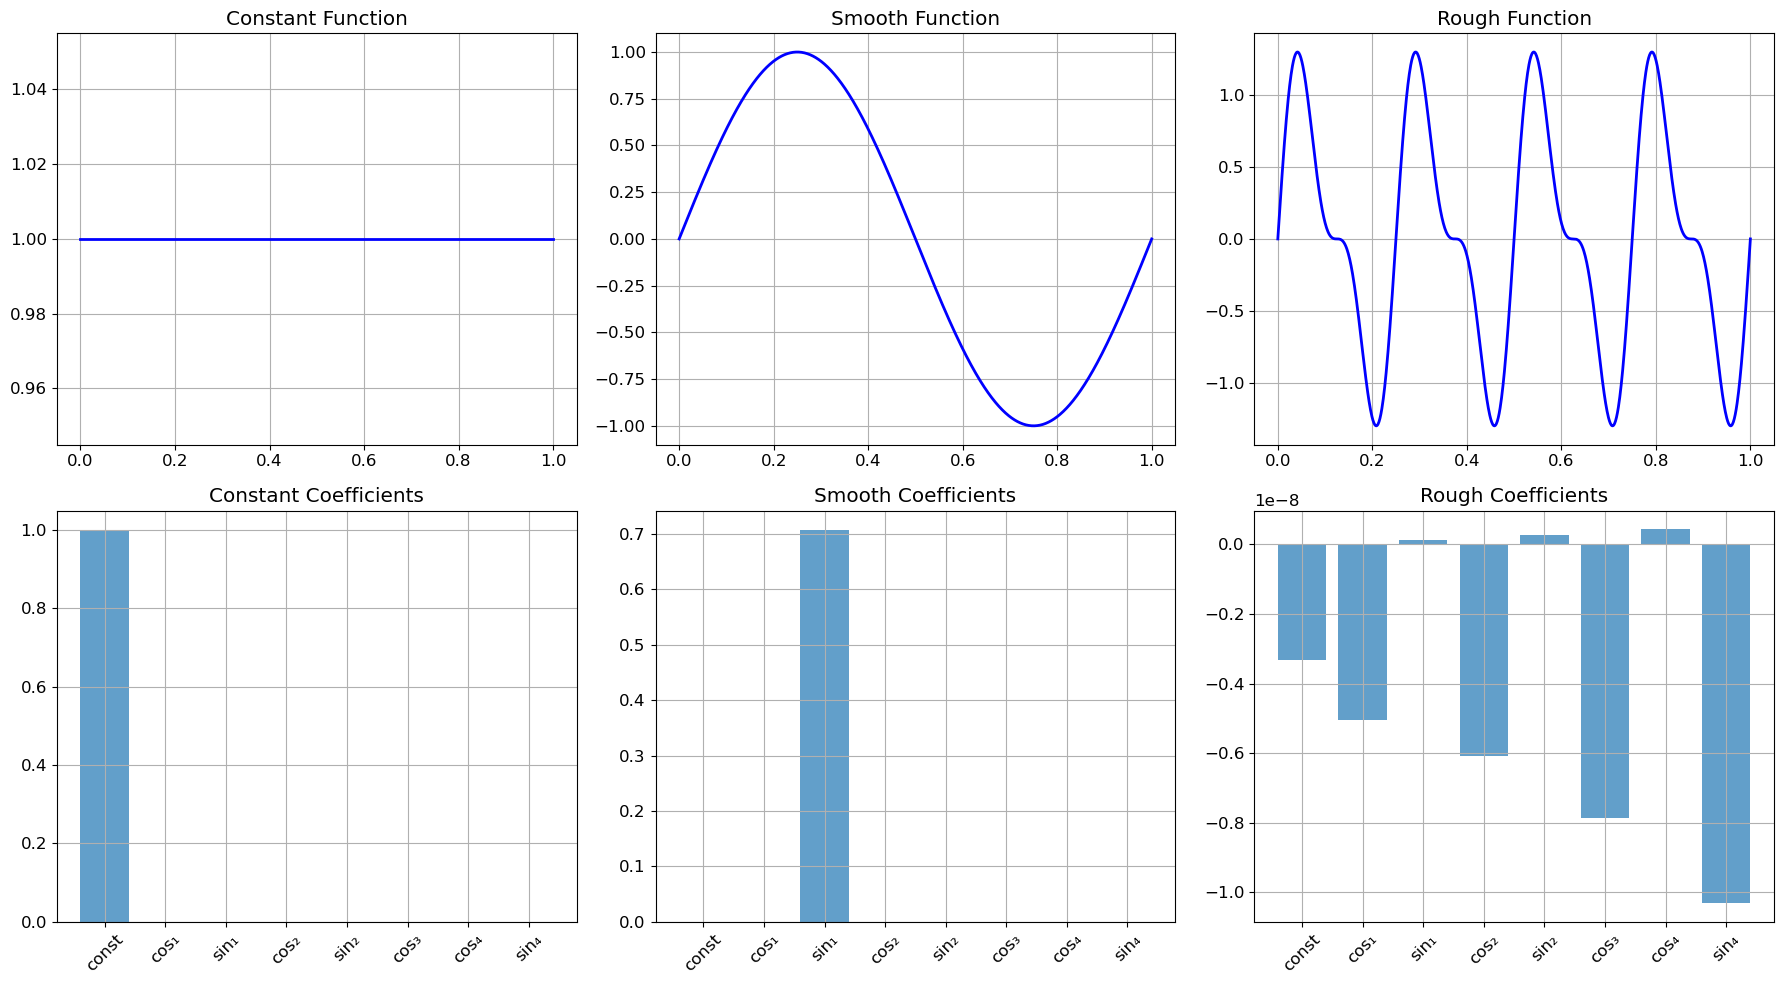


Reconstruction test (coefficient-based):
Constant: max coefficient error = 0.00e+00
  Constant: function evaluation error at x=0.5 = 0.00e+00
Smooth: max coefficient error = 5.55e-17
  Smooth: function evaluation error at x=0.5 = 1.64e-16
Rough: max coefficient error = 8.27e-25
  Rough: function evaluation error at x=0.5 = 8.28e-09


/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:250: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


In [9]:
print("=== Coefficient Representation ===")

# Analyze coefficient representation of our test functions
functions = [(const_func, 'Constant'), (smooth_func, 'Smooth'), (rough_func, 'Rough')]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (func, name) in enumerate(functions):
    # Get coefficients
    coeffs = h1.to_components(func)

    # Plot function
    x = np.linspace(0, 1, 1000)
    axes[0, idx].plot(x, func.evaluate(x), 'b-', linewidth=2)
    axes[0, idx].set_title(f'{name} Function')
    axes[0, idx].grid(True)

    # Plot coefficients
    basis_names = ['const', 'cos₁', 'sin₁', 'cos₂', 'sin₂', 'cos₃', 'cos₄', 'sin₄'][:len(coeffs)]
    axes[1, idx].bar(range(len(coeffs)), coeffs, alpha=0.7)
    axes[1, idx].set_xticks(range(len(coeffs)))
    axes[1, idx].set_xticklabels(basis_names, rotation=45)
    axes[1, idx].set_title(f'{name} Coefficients')
    axes[1, idx].grid(True)

plt.tight_layout()
plt.show()

# Test reconstruction by comparing coefficients directly
print("\nReconstruction test (coefficient-based):")
for func, name in functions:
    original_coeffs = h1.to_components(func)
    reconstructed = h1.from_components(original_coeffs)
    reconstructed_coeffs = h1.to_components(reconstructed)

    max_coeff_error = np.max(np.abs(original_coeffs - reconstructed_coeffs))
    print(f"{name}: max coefficient error = {max_coeff_error:.2e}")

    # Test a simple evaluation at x=0.5 for sanity check
    try:
        orig_val = func.evaluate(0.5)
        recon_val = reconstructed.evaluate(0.5)
        eval_error = abs(orig_val - recon_val)
        print(f"  {name}: function evaluation error at x=0.5 = {eval_error:.2e}")
    except Exception as e:
        print(f"  {name}: evaluation test skipped due to error: {type(e).__name__}")

## 10. Advanced Features

Demonstrating advanced features like automorphisms and Gaussian measures.

=== Advanced Features ===

1. Automorphism example:


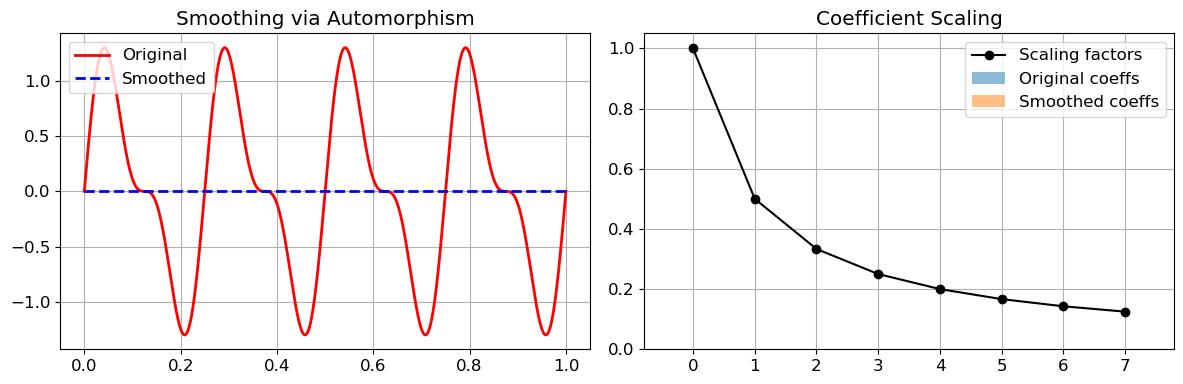


2. Gaussian measure (random function generation):
✓ Gaussian measure created with covariance scaling 1/(1+k²)
  This would generate random functions with decreasing high-frequency content


In [10]:
print("=== Advanced Features ===")

# 1. Automorphism (applies different scaling to each mode)
print("\n1. Automorphism example:")
def mode_scaling(k):
    """Scale higher modes less (smoothing effect)"""
    return 1.0 / (1.0 + k)

smoothing_op = h1.automorphism(mode_scaling)
smoothed_rough = smoothing_op(rough_func)

# Compare original and smoothed
x = np.linspace(0, 1, 1000)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x, rough_func.evaluate(x), 'r-', label='Original', linewidth=2)
axes[0].plot(x, smoothed_rough.evaluate(x), 'b--', label='Smoothed', linewidth=2)
axes[0].set_title('Smoothing via Automorphism')
axes[0].legend()
axes[0].grid(True)

# Show coefficient scaling
orig_coeffs = h1.to_components(rough_func)
smooth_coeffs = h1.to_components(smoothed_rough)
scaling_factors = [mode_scaling(k) for k in range(len(orig_coeffs))]

axes[1].bar(range(len(orig_coeffs)), orig_coeffs, alpha=0.5, label='Original coeffs')
axes[1].bar(range(len(smooth_coeffs)), smooth_coeffs, alpha=0.5, label='Smoothed coeffs')
axes[1].plot(scaling_factors, 'ko-', label='Scaling factors')
axes[1].set_title('Coefficient Scaling')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 2. Gaussian measure
print("\n2. Gaussian measure (random function generation):")
def covariance_scaling(k):
    """Covariance decreases with mode number (smoother random functions)"""
    return 1.0 / (1.0 + k**2)

gaussian_measure = h1.gaussian_measure(covariance_scaling)
print(f"✓ Gaussian measure created with covariance scaling 1/(1+k²)")
print(f"  This would generate random functions with decreasing high-frequency content")

## 11. Lebesgue Space (L²) Convenience Class

The `Lebesgue` class is a convenience wrapper for L² spaces.

In [11]:
print("=== Lebesgue (L²) Space ===")

from pygeoinf.interval.sobolev_space import Lebesgue

# Create L² space using Lebesgue class
l2_domain = IntervalDomain(0, 1)
l2_space = Lebesgue(6, function_domain=l2_domain)

print(f"L² space: dim={l2_space.dim}, order={l2_space.order}")
print(f"Basis type: {l2_space.basis_type}")
print(f"Eigenvalues: {l2_space.eigenvalues}")

# Create function in L² space
l2_func = L2Function(l2_space, evaluate_callable=smooth_function, name='smooth_l2')

# Compare L² norm with H¹ norm
l2_norm_sq = l2_space.inner_product(l2_func, l2_func)
h1_func = L2Function(h1, evaluate_callable=smooth_function, name='smooth_h1')
h1_norm_sq = h1.inner_product(h1_func, h1_func)

print(f"\n||sin(2πx)||²_L² = {l2_norm_sq:.6f}")
print(f"||sin(2πx)||²_H¹ = {h1_norm_sq:.6f}")
print(f"Ratio H¹/L² = {h1_norm_sq/l2_norm_sq:.2f}")

print("\n✓ Lebesgue class works as expected (H⁰ = L² space)")

=== Lebesgue (L²) Space ===
L² space: dim=6, order=0.0
Basis type: fourier
Eigenvalues: [  0.          39.4784176   39.4784176  157.91367042 157.91367042
 355.30575844]

||sin(2πx)||²_L² = 0.500000
||sin(2πx)||²_H¹ = 20.239209
Ratio H¹/L² = 40.48

✓ Lebesgue class works as expected (H⁰ = L² space)
